# Project Title: Udacity - Data Engineer Capstone Project

## Project Summary


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Import Libraries

In [66]:
import os
import configparser
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

### Load Configuration Data

In [67]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

### Create a Spark Session

In [68]:
spark = SparkSession.builder \
    .config("spark.jars.repositories", "https://repos.spark-packages.org/") \
    .config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11") \
    .enableHiveSupport() \
    .getOrCreate()

df_spark = spark.read \
                .format('com.github.saurfang.sas.spark') \
                .load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

### Read file SAS and write to a parquet file

In [69]:
# df_spark.write.mode('overwrite').parquet("./inputs/sas_data")
# df_spark=spark.read.parquet("./inputs/sas_data")

## Step 1: Scope the Project and Gather Data
<hr style="background-color: #b7d0e2;"/> 

### Project Scope:

This project will use I94 immigration raw data, world temperature raw data and demographic raw data to create dim fact tables for analytical purposes.

- Data used for building:
    > I94 immigration raw data `../../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat`
    > World temperature raw data `../../data2/GlobalLandTemperaturesByCity.csv`
    > Demographic raw data `us-cities-demographics.csv`
- Coding:
    > PySpark framework
    > Pandas for data exploration and plot chart
    > Amazon S3 for running on cloud

### 1.1 I94 Immigration Data
<hr style="background-color: #b7d0e2;"/> 


In [70]:
# Load I94 Immigration data
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_dataset =spark.read.format('com.github.saurfang.sas.spark').load(fname)

# fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
# df = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")

In [71]:
# Limit data rows for better processing speed (3096313 -> 500) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
immigration_dataset = immigration_dataset.limit(500)

In [72]:
# display the first five records
immigration_dataset.limit(5).toPandas()

# immigration_df.show(5, truncate = False)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [73]:
# count the total number of records
immigration_dataset.count()

500

In [74]:
# column names in immigration_dataset
print(immigration_dataset.columns, end = '')

['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype']

<b><i>Data dictionary -> I94 immigration dataset</i></b>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">cicid</td><td class="tg-0pky">Unique record ID</td>
 <tr><td class="tg-0pky">i94yr</td><td class="tg-0pky">4 digit year</td>
 <tr><td class="tg-0pky">i94mon</td><td class="tg-0pky">Numeric month</td>
 <tr><td class="tg-0pky">i94cit</td><td class="tg-0pky">3 digit code for immigrant country of birth</td>
 <tr><td class="tg-0pky">i94res</td><td class="tg-0pky">3 digit code for immigrant country of residence </td>
 <tr><td class="tg-0pky">i94port</td><td class="tg-0pky">Port of admission</td>
 <tr><td class="tg-0pky">arrdate</td><td class="tg-0pky">Arrival Date in the USA</td>
 <tr><td class="tg-0pky">i94mode</td><td class="tg-0pky">Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td>
 <tr><td class="tg-0pky">i94addr</td><td class="tg-0pky">USA State of arrival</td>
 <tr><td class="tg-0pky">depdate</td><td class="tg-0pky">Departure Date from the USA</td>
 <tr><td class="tg-0pky">i94bir</td><td class="tg-0pky">Age of Respondent in Years</td>
 <tr><td class="tg-0pky">i94visa</td><td class="tg-0pky">Visa codes collapsed into three categories</td>
 <tr><td class="tg-0pky">count</td><td class="tg-0pky">Field used for summary statistics</td>
 <tr><td class="tg-0pky">dtadfile</td><td class="tg-0pky">Character Date Field - Date added to I-94 Files</td>
 <tr><td class="tg-0pky">visapost</td><td class="tg-0pky">Department of State where where Visa was issued </td>
 <tr><td class="tg-0pky">occup</td><td class="tg-0pky">Occupation that will be performed in U.S</td>
 <tr><td class="tg-0pky">entdepa</td><td class="tg-0pky">Arrival Flag - admitted or paroled into the U.S.</td>
 <tr><td class="tg-0pky">entdepd</td><td class="tg-0pky">Departure Flag - Departed, lost I-94 or is deceased</td>
 <tr><td class="tg-0pky">entdepu</td><td class="tg-0pky">Update Flag - Either apprehended, overstayed, adjusted to perm residence</td>
 <tr><td class="tg-0pky">matflag</td><td class="tg-0pky">Match flag - Match of arrival and departure records</td>
 <tr><td class="tg-0pky">biryear</td><td class="tg-0pky">4 digit year of birth</td>
 <tr><td class="tg-0pky">dtaddto</td><td class="tg-0pky">Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td>
 <tr><td class="tg-0pky">gender</td><td class="tg-0pky">Non-immigrant sex</td>
 <tr><td class="tg-0pky">insnum</td><td class="tg-0pky">INS number</td>
 <tr><td class="tg-0pky">airline</td><td class="tg-0pky">Airline used to arrive in U.S.</td>
 <tr><td class="tg-0pky">admnum</td><td class="tg-0pky">Admission Number</td>
 <tr><td class="tg-0pky">fltno</td><td class="tg-0pky">Flight number of Airline used to arrive in U.S.</td>
 <tr><td class="tg-0pky">visatype</td><td class="tg-0pky">Class of admission legally admitting the non-immigrant to temporarily stay in U.S.</td>
</table>

### 1.2 World Temperature Data: Data Description 
<hr style="background-color: #b7d0e2;"/> 


In [75]:
# Load World Temperature data
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_dataset = spark.read.csv(file_name, header=True, inferSchema=True)

In [76]:
# Limit data rows for better processing speed (8599212 -> 800) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
temperature_dataset = temperature_dataset.limit(800)

In [77]:
# display the first five records
temperature_dataset.limit(5).toPandas()

#temperature_df.show(n=5, truncate = False)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


<b><i>Data dictionary -> World Temperature Data</i></b>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">dt</td><td class="tg-0pky">Date</td>
 <tr><td class="tg-0pky">AverageTemperature</td><td class="tg-0pky">Global average land temperature in celsius</td>
 <tr><td class="tg-0pky">AverageTemperatureUncertainty</td><td class="tg-0pky">95% confidence interval around the average</td>
 <tr><td class="tg-0pky">City</td><td class="tg-0pky">Name of City</td>
 <tr><td class="tg-0pky">Country</td><td class="tg-0pky">Name of Country</td>
 <tr><td class="tg-0pky">Latitude</td><td class="tg-0pky">City Latitude</td>
 <tr><td class="tg-0pky">Longitude</td><td class="tg-0pky">City Longitude</td>
</table>

In [78]:
# check the total number of records
temperature_dataset.count()

800

In [79]:
# column names in temperature_df
print(temperature_dataset.columns, end = '')

['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']

### 1.3 U.S. City Demographic Data: Data Description 
<hr style="background-color: #b7d0e2;"/> 


In [80]:
# Load U.S. City Demographic Data
file_name = "./inputs/us-cities-demographics.csv"
demographics_dataset = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')

In [81]:
# display the first five records
demographics_dataset.limit(5).toPandas()

# demographics_dataset.show(5, truncate = False)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


<b><i>Data dictionary -> U.S. City Demographic Data</i></b>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">City</td><td class="tg-0pky">City Name</td>
 <tr><td class="tg-0pky">State</td><td class="tg-0pky">US State where city is located</td>
 <tr><td class="tg-0pky">Median Age</td><td class="tg-0pky">Median age of the population</td>
 <tr><td class="tg-0pky">Male Population</td><td class="tg-0pky">Count of male population</td>
 <tr><td class="tg-0pky">Female Population</td><td class="tg-0pky">Count of female population</td>
 <tr><td class="tg-0pky">Total Population</td><td class="tg-0pky">Count of total population</td>
 <tr><td class="tg-0pky">Number of Veterans</td><td class="tg-0pky">Count of total Veterans</td>
 <tr><td class="tg-0pky">Foreign born</td><td class="tg-0pky">Count of residents of the city that were not born in the city</td>
 <tr><td class="tg-0pky">Average Household Size</td><td class="tg-0pky">Average city household size</td>
 <tr><td class="tg-0pky">State Code</td><td class="tg-0pky">Code of the US state</td>
 <tr><td class="tg-0pky">Race</td><td class="tg-0pky">Respondent race</td>
 <tr><td class="tg-0pky">Count</td><td class="tg-0pky">Count of city's individual per race</td>
</table>

In [82]:
# check the total number of records
demographics_dataset.count()

2891

In [83]:
# column names in demographics_df
print(demographics_dataset.columns, end = '')

['City', 'State', 'Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'State Code', 'Race', 'Count']

## Step 2: Explore and Assess the Data

## 2.1 Immigration data

### 2.1.1 Explore: Immigration data
---

In [84]:
# list all files in the customer repository
files = os.listdir('../../data/18-83510-I94-Data-2016/')
files

['i94_apr16_sub.sas7bdat',
 'i94_sep16_sub.sas7bdat',
 'i94_nov16_sub.sas7bdat',
 'i94_mar16_sub.sas7bdat',
 'i94_jun16_sub.sas7bdat',
 'i94_aug16_sub.sas7bdat',
 'i94_may16_sub.sas7bdat',
 'i94_jan16_sub.sas7bdat',
 'i94_oct16_sub.sas7bdat',
 'i94_jul16_sub.sas7bdat',
 'i94_feb16_sub.sas7bdat',
 'i94_dec16_sub.sas7bdat']

In [85]:
# immigration_df schema
immigration_dataset.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

### 2.1.2 Visualize Missing Values: Immigration data
---

In [86]:
# ######################################## testing ######################################################

# def check_df(df):
#     nan_count_df = df.select(
#         [F.count( \
#                 F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) \
#          for c in df.columns] \
#     ).toPandas()

#     # convert dataframe from wide format to long format
#     nan_count_df = pd.melt(nan_count_df, var_name='cols', value_name='values')

#     # count total records in df
#     total = df.count()

#     # now lets add % missing values column
#     nan_count_df['% missing values'] = 100*nan_count_df['values']/total
    
#     return nan_count_df

# check_df(immigration_df).head(5)

# #pandas -> .head()
# #pyspark -> .show()


# ######################################## testing ######################################################

In [87]:
def plot_missing_values_spark(df):
    """
    Visualize missing values in a spark dataframe
    """
    # create a dataframe with missing values count per column
    nan_count_df = df.select(
        [F.count( \
                F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) \
         for c in df.columns] \
    ).toPandas()
    # convert dataframe from wide format to long format
    nan_count_df = pd.melt(nan_count_df, var_name='cols', value_name='values')
    # now lets add % missing values column
    nan_count_df['percent_of_missing'] = 100 * nan_count_df['values'] / df.count() # count total records in missing value data_frame
    
    plt.rcdefaults()
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x="cols", y="percent_of_missing", data=nan_count_df)
    ax.set_ylim(0, 100)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

In [88]:
# ################################################# testing pandas #################################################################
# # View columns with missing data
# nulls_df = pd.DataFrame(data=immigration_df.toPandas().isnull().sum(), columns=['values'])
# nulls_df = nulls_df.reset_index()
# nulls_df.columns = ['cols', 'values']

# # calculate % missing values
# nulls_df['% missing values'] = 100*nulls_df['values']/immigration_df.count()
# nulls_df[nulls_df['% missing values']>0]

# ################################################# testing pandas #################################################################

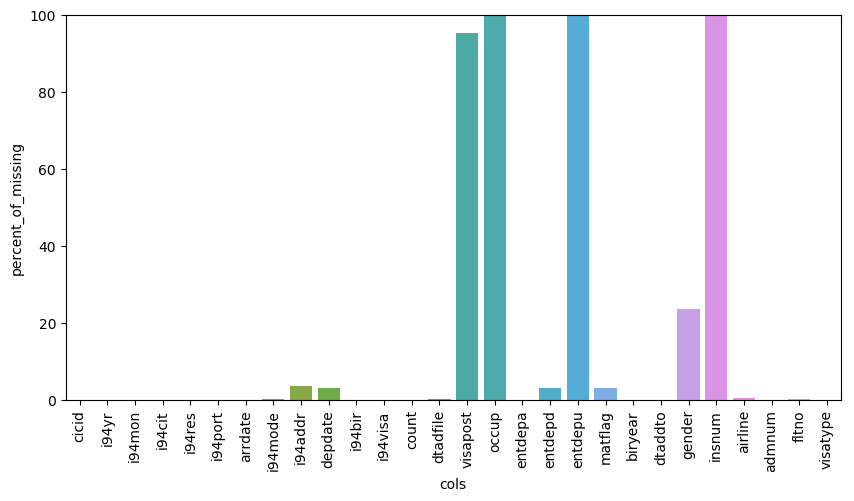

In [89]:
# plot missing values for immigration_df
plot_missing_values_spark(immigration_dataset)

### 2.1.3 Data Cleaning: Immigration data
---

- Drop all rows with 100% missing values. 
- Drop all columns with over 90% missing values because columns with over 90% missing values are not deemed to contain sufficient data to be used for analytics.
- Drop duplicated rows.
- Drop rows with missing values.

In [90]:
# columns with over 90% missing values
drop_columns = ['occup', 'entdepu','insnum']

# drop these missing values columns
immigration_dataset = immigration_dataset.drop(*drop_columns)

In [91]:
# drop duplicate entries
immigration_dataset = immigration_dataset.dropDuplicates(['cicid'])

In [92]:
# get a count after dropping duplicates
immigration_dataset.count()

500

In [93]:
# drop rows with missing values
immigration_dataset = immigration_dataset.dropna(how='all', subset=['cicid'])

In [94]:
# get a count after dropping rows with missing values
immigration_dataset.count()

500

In [95]:
immigration_dataset = immigration_dataset.drop_duplicates(subset=immigration_dataset.columns)

In [96]:
# display the new schema
immigration_dataset.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [97]:
immigration_dataset.limit(5).toPandas()

# new_immigration_df.show(5)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,T,None,None,1979.0,10282016,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,G,None,None,1991.0,D/S,M,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,T,O,M,1961.0,09302016,M,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,O,O,M,1988.0,09302016,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,O,O,M,2012.0,09302016,None,AA,9.246846e+10,00199,B2


In [98]:
## Minimized the immigration data to build data warehouse faster
# immigration_dataset = immigration_dataset.take(30000)

## 2.2 World Temperature Data

### 2.2.1 Explore: World Temperature data
---

In [99]:
# print dataframe schema
temperature_dataset.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



### 2.2.2 Visualize Missing Values: World Temperature data
---

In [100]:
# create temperature_df_casted with column 'dt' casted to string type -> to plot chart
temperature_dataset_casted = temperature_dataset \
                        .withColumn("dt", 
                                    F.col("dt").cast(T.StringType())
                                   ) # convert dt column type to string

In [101]:
# ################################################# testing pandas #################################################################
# # View columns with missing data
# nulls_df = pd.DataFrame(data=temperature_df_casted.toPandas().isnull().sum(), columns=['values'])
# nulls_df = nulls_df.reset_index()
# nulls_df.columns = ['cols', 'values']

# # calculate % missing values
# nulls_df['% missing values'] = 100*nulls_df['values']/temperature_df_casted.count()
# nulls_df[nulls_df['% missing values']>0]

# ################################################# testing pandas #################################################################

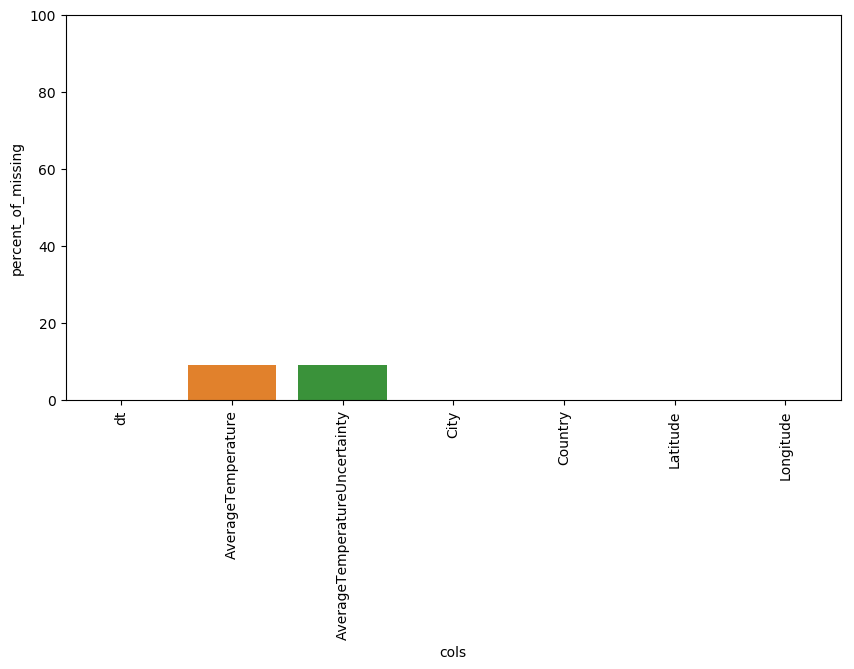

In [102]:
# visualize missing values in temperature_df_casted
plot_missing_values_spark(temperature_dataset_casted)

### 2.2.3 Data Cleaning: World Temperature data
---

- Drop rows with missing average temperature.
- Drop duplicated rows.

In [103]:
# Drop rows missing AverageTemperature
temperature_dataset = temperature_dataset.dropna(how='all', subset=['AverageTemperature'])

In [104]:
temperature_dataset.count()

728

In [105]:
# drop duplicate entries
temperature_dataset = temperature_dataset.dropDuplicates(subset=['dt', 'City', 'Country'])

In [106]:
temperature_dataset.count()

728

In [107]:
temperature_dataset.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [108]:
temperature_dataset.limit(5).toPandas()

# temperature_dataset.show(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
2,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
3,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
4,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


## 2.3 U.S. City Demographic Data

### 2.3.1 Explore: U.S. City Demographic Data
---

In [109]:
# print database schema
demographics_dataset.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [110]:
# count the number of records in dataset
demographics_dataset.count()

2891

### 2.3.2 Visualize Missing Values: U.S. City Demographic Data
---

In [111]:
# ######################################### testing pandas ###########################################
# # View columns with missing data
# nulls_df = pd.DataFrame(data=demographics_df.toPandas().isnull().sum(), columns=['values'])
# nulls_df = nulls_df.reset_index()
# nulls_df.columns = ['cols', 'values']

# # calculate % missing values
# nulls_df['% missing values'] = 100*nulls_df['values']/demographics_df.count()
# nulls_df[nulls_df['% missing values']>0]
# ######################################### testing pandas ###########################################

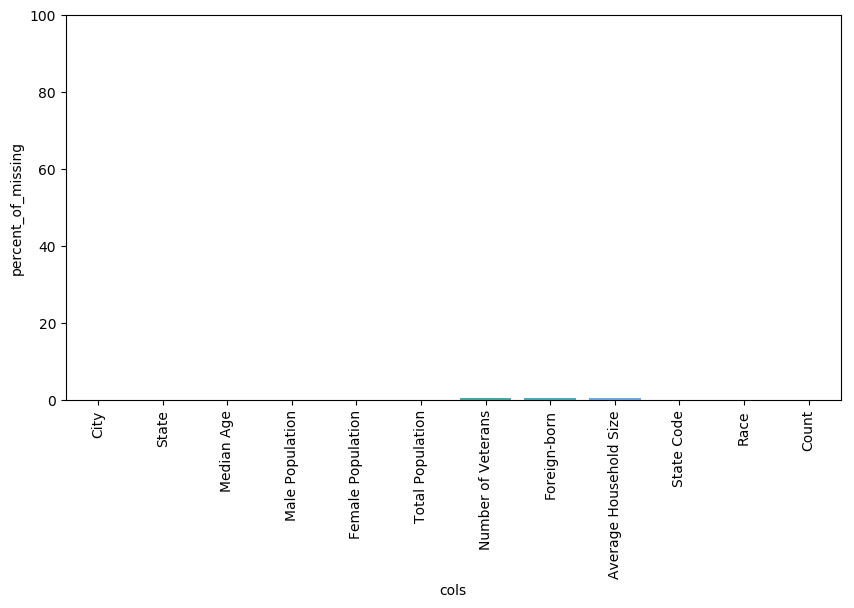

In [112]:
plot_missing_values_spark(demographics_dataset)

### 2.3.3 Data Cleaning: U.S. City Demographic Data
---

- This dataset has very few missing values, thus it is safe to drop records with missing values.
- Drop duplicate columns

In [113]:
# drop rows with missing value in demographics data
processing_dropna_cols = ['Male Population',
                          'Female Population',
                          'Number of Veterans',
                          'Foreign-born',
                          'Average Household Size'
                         ]

demographics_dataset = demographics_dataset.dropna(how='all', subset=processing_dropna_cols)

In [114]:
# drop duplicate rows
processing_drop_duplicates_cols = ['City', 'State', 'State Code', 'Race']
demographics_dataset = demographics_dataset.drop_duplicates(subset=processing_drop_duplicates_cols)

In [115]:
# count the number of records in dataset
demographics_dataset.count()

2891

In [116]:
demographics_dataset.limit(5).toPandas()

# demographics_dataset.show(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
1,Wilmington,North Carolina,35.5,52346,63601,115947,5908,7401,2.24,NC,Asian,3152
2,Tampa,Florida,35.3,175517,193511,369028,20636,58795,2.47,FL,Hispanic or Latino,95154
3,Gastonia,North Carolina,36.9,35527,39023,74550,3537,5715,2.67,NC,Asian,2788
4,Tyler,Texas,33.9,50422,53283,103705,4813,8225,2.59,TX,American Indian and Alaska Native,1057


# Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

![Database schema](immigration_data_model.png)

- **fact_immigration**:  created from raw data I94 lablel description `I94_SAS_Labels_Descriptions.SAS`
- **dim_calendar**: Derived from I94 dataset
- **dim_visatypes**: Derived from I94 dataset
- **dim_countries**: Mapped I94 dataset with `i94res.csv` and temperature dataset `../../data2/GlobalLandTemperaturesByCity.csv`.
- **dim_demographics**: created from `us-cities-demographics.csv`


#### 3.2 Mapping Out Data Pipelines
Data pipeline processing steps:
- 1. Load the raw data `I94_SAS_Labels_Descriptions.SAS` from `inputs` folder -> `immigration_dataset`
- 2. Clean `immigration_dataset` -> dropna and duplicated rows
- 3. Derive `immigration_dataset` -> `dim_visatypies`, `dim_calendar` and `temperature_dataset`
- 4. Load and clean `i94res.csv` -> `i94res_mapping_dataset`
- 5. Map `i94res_mapping_dataset` with `temperature_dataset` and `immigration_dataset` -> `dim_countries`
- 6. Load and clean `us-cities-demographics.csv` -> `dim_demographics`
- 7. Create `fact_immigration`
- 8. Return dim fact tables for `data quality checks`

## Step 4: Run Pipelines to Model the Data 
### 4.1 Create the data model


#### Create the dim_calendar
---

In [117]:
global get_datetime
get_datetime = F.udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)

In [118]:
def dim_calendar_spark(immigration_dataset, output_data):
    """
    Create dim_calendar from immigration_dataset
    """

    dim_calendar = immigration_dataset.select(F.col('arrdate')) \
                                      .withColumn("arrdate", get_datetime(immigration_dataset.arrdate)) \
                                      .distinct()

    dim_calendar = dim_calendar.withColumn('arrival_day', F.dayofmonth('arrdate'))
    dim_calendar = dim_calendar.withColumn('arrival_week', F.weekofyear('arrdate'))
    dim_calendar = dim_calendar.withColumn('arrival_month', F.month('arrdate'))
    dim_calendar = dim_calendar.withColumn('arrival_year', F.year('arrdate'))
    dim_calendar = dim_calendar.withColumn('arrival_weekday', F.dayofweek('arrdate'))

    dim_calendar = dim_calendar.withColumn('id', F.monotonically_increasing_id())

    partition_by_columns = ['arrival_year', 'arrival_month', 'arrival_week']
    dim_calendar.write.parquet(output_data + "dim_calendar", partitionBy=partition_by_columns, mode="overwrite")

    return dim_calendar

In [119]:
output_data = "./outputs/"
dim_calendar = dim_calendar_spark(immigration_dataset, output_data)
dim_calendar.show(5)

+----------+-----------+------------+-------------+------------+---------------+------------+
|   arrdate|arrival_day|arrival_week|arrival_month|arrival_year|arrival_weekday|          id|
+----------+-----------+------------+-------------+------------+---------------+------------+
|2016-04-01|          1|          13|            4|        2016|              6|206158430208|
|2016-04-07|          7|          14|            4|        2016|              5|326417514496|
|2016-04-29|         29|          17|            4|        2016|              6|481036337152|
+----------+-----------+------------+-------------+------------+---------------+------------+



In [120]:
# # extract to csv file
# dim_calendar.toPandas().to_csv('calendar_df.cvs', index=False)

#### Create the dim_countries
---

In [121]:
def aggregate_temperature_data(temperature_dataset):
    """
    Aggregate cleaned temperature_dataset to get average_temperature column
    """
    agg_temperature_dataset = temperature_dataset.select(F.col('Country'), F.col('AverageTemperature')) \
                                                 .groupby(F.col('Country')) \
                                                 .avg()
    agg_temperature_dataset = agg_temperature_dataset.withColumnRenamed('avg(AverageTemperature)', \
                                                                        'average_temperature')
    # note: new column renamed => not use F.col('...') 
    
    return agg_temperature_dataset

In [122]:
import pandas as pd

df = pd.read_csv('./inputs/us-cities-demographics.csv', sep=';')

df.head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [123]:
def dim_countries_spark(spark, \
                        immigration_dataset, \
                        temperature_dataset, \
                        output_data, \
                        i94res_mapping_dataset):
    """
    Create dim_countries by mapping the i94res_mapping_dataset with temperature_dataset and 
    """
    immigration_dataset = immigration_dataset.withColumnRenamed('i94res', 'country_code')
    dim_countries = immigration_dataset.join(i94res_mapping_dataset, \
                                             immigration_dataset.country_code == i94res_mapping_dataset.code, \
                                             'left') \
                                       .distinct()
    dim_countries = dim_countries.withColumnRenamed('Name', 'country_name')
    
    agg_temperature_dataset = utils.aggregate_temperature_data(temperature_dataset)
    dim_countries = dim_countries.join(agg_temperature_dataset, \
                                       dim_countries.country_name == agg_temperature_dataset.Country, \
                                       'left') \
                                 .distinct()
    
    dim_countries = dim_countries.select(F.col('country_code'), \
                                         F.col('country_name'), \
                                         F.col('average_temperature'))
#     dim_countries = dim_countries.select('country_code', 'country_name', 'average_temperature')
    
    return dim_countries

In [124]:
dim_countries = dim_countries_spark(immigration_dataset, temperature_dataset, output_data, i94res_mapping_dataset)
dim_countries.show(5)

NameError: name 'i94res_mapping_dataset' is not defined

In [ ]:
# # extract to csv file
# dim_countries.toPandas().to_csv('dim_countries.cvs', index=False)

#### Create dim_visatypes
---

In [ ]:
def dim_visatypes_spark(immigration_dataset, output_data):
    """
    Create dim_visatypes from immigration_dataset
    """
    dim_visatypes = immigration_dataset.select('visatype').distinct()
    dim_visatypes = dim_visatypes.withColumn('visa_type_key', F.monotonically_increasing_id())
    dim_visatypes.write.parquet(output_data + "dim_visatypes", mode="overwrite")

    return dim_visatypes

In [ ]:
# test create visa_type dimension function
dim_visatypes = dim_visatypes_spark(immigration_dataset, output_data)
dim_visatypes.show(5)

In [ ]:
# # extract to csv file
# dim_visatypes.toPandas().to_csv('dim_visatypes.cvs', index=False)

#### Create the dim_demographics
---

In [ ]:
def dim_demographics_spark(demographics_dataset, output_data):
    """
    Enrich demographics_dataset, add id column => dim_demographics table
    """
    demographics_dataset = demographics_dataset.withColumnRenamed('Median Age', 'median_age') \
                                                .withColumnRenamed('Male Population', 'male_population') \
                                                .withColumnRenamed('Female Population', 'female_population') \
                                                .withColumnRenamed('Total Population', 'total_population') \
                                                .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
                                                .withColumnRenamed('Foreign-born', 'foreign_born') \
                                                .withColumnRenamed('Average Household Size', 'average_household_size') \
                                                .withColumnRenamed('State Code', 'state_code')

    dim_demographics = demographics_dataset.withColumn('id', F.monotonically_increasing_id())
    dim_demographics.write.parquet(output_data + "dim_demographics", mode="overwrite")

    return dim_demographics

In [ ]:
dim_demographics = dim_demographics_spark(demographics_dataset, output_data)
dim_demographics.limit(5).toPandas()

In [ ]:
# # extract to csv file
# dim_demographics.toPandas().to_csv('dim_demographics.cvs', index=False)

#### Create the fact_immigration
---

In [ ]:
def fact_immigration_spark(spark, \
                           immigration_dataset, \
                           output_data, \
                           dim_visatypes):
    """
    Creates fact_immigration table from immigration_dataset.
    """
    # rename columns to align with data model
    fact_immigration = immigration_dataset.withColumnRenamed('ccid', 'record_id') \
                                          .withColumnRenamed('i94res', 'country_residence_code') \
                                          .withColumnRenamed('i94addr', 'state_code')
    
    initial_immigration_columns = fact_immigration["*"]
    fact_immigration = fact_immigration.select(initial_immigration_columns) \
                                       .join(dim_visatypes, \
                                             fact_immigration.visatype == dim_visatypes.visatype, \
                                             'left')\
                                       .distinct()
    # fact_immigration.columns << OR >> fact_immigration['*']
    fact_immigration = fact_immigration.select(initial_immigration_columns, \
                                               F.col('visa_type_key'))
    # because dim_visatypes was derived from immigration dataset => no need to select specific columns for fact_immigration after join.
    # fact_immigration["*"]  ...  return columns type !!!
    
    # create arrival date with datetime type
    fact_immigration = fact_immigration.withColumn("arrdate", get_datetime(fact_immigration.arrdate))

    fact_immigration = fact_immigration.drop(fact_immigration.visatype)
    fact_immigration.write.parquet(output_data + "fact_immigration", mode="overwrite")

    return fact_immigration

In [ ]:
fact_immigration = fact_immigration_spark(spark, immigration_dataset, output_data, dim_visatypes)

In [ ]:
fact_immigration.limit(5).toPandas()

In [ ]:
# # extract to csv file
# fact_immigration.toPandas().to_csv('fact_immigration.cvs', index=False)

In [ ]:
# def run_pipeline():
#     # load data
    
#     # run cleaning functions
    
#     # create fact and dimension tables

### 4.2 Data Quality Checks
Check to make sure: No empty dim fact tables after running ETL data pipeline.
 
Run Quality Checks

In [ ]:
# colmns_expected_fact_immigration = 
# colmns_expected_dim_visatypes = 
# colmns_expected_dim_calendar = 
# colmns_expected_dim_demographics = 
# colmns_expected_dim_countries = 

## for columns existence checking 

In [ ]:
def quality_checks(df, table_name):
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count:,} records.")
        
    
    
    return 0

In [ ]:
table_dfs = {
    'immigration_fact': fact_immigration,
    'visa_type_dim': dim_visatypes,
    'calendar_dim': dim_calendar,
    'usa_demographics_dim': dim_demographics,
    'country_dim': dim_countries
}



for table_name, table_df in table_dfs.items():
    quality_checks(table_df, table_name)
    
##    for columns existence checking
#     for col in table_df.columns:
#         if col in 

### 4.3 Data dictionary 
Data dictionary was created during Explore Data configurations in this Notebook.

## Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.